# Optimizing Model Parameters

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

## Loading Datasets

In [2]:
training_datasets = datasets.FashionMNIST(root='../data', train=True, download=True, transform=transforms.ToTensor())
test_datasets = datasets.FashionMNIST(root='../data', train=False, download=True, transform=transforms.ToTensor())

## Visualizing Datasets

Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


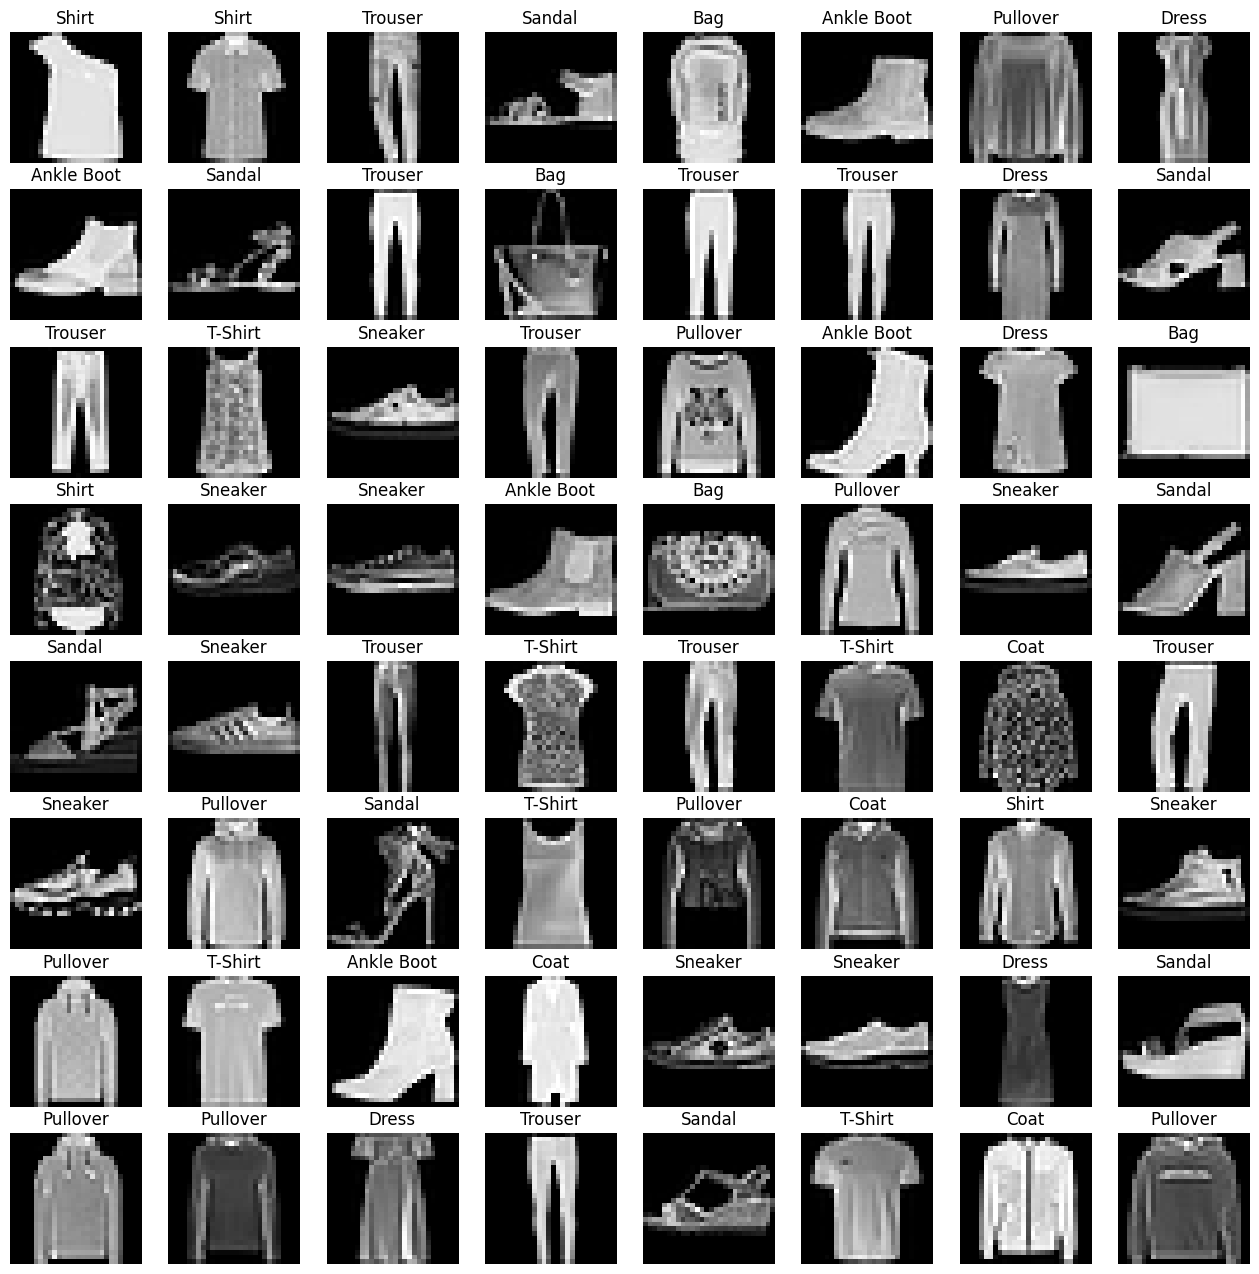

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

training_dataloader = DataLoader(training_datasets, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=64, shuffle=True)

for images, labels in training_dataloader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    figure = plt.figure(figsize=(16, 16))
    cols, rows = 8, 8
    for i in range(1, cols * rows + 1):
        img, label =images[i-1], labels[i-1]
        figure.add_subplot(rows, cols, i)
        plt.title(labels_map[label.item()])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

    break

## Building neural network

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

torch.Size([1, 1, 28, 28])


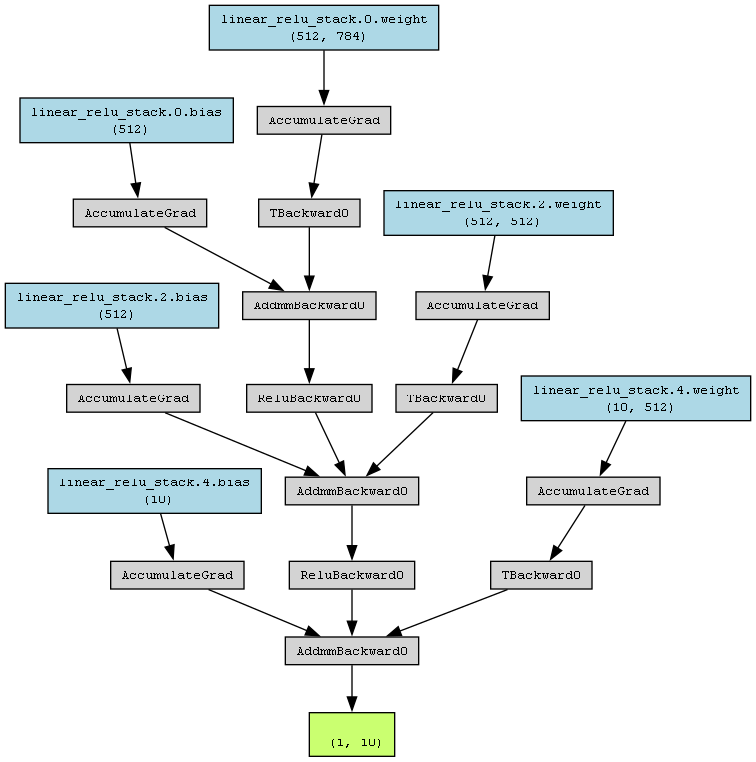

In [5]:
from torchviz import make_dot
from IPython.display import Image, display

model = NeuralNetwork().to(device)
dummy_input = torch.randn(1, 1, 28, 28, device=device).to(device)
print(dummy_input.shape)
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))
display(Image(dot.pipe(format='png')))


## Setting Parameters Optimize

In [6]:
learning_rate = 1e-3
epochs = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Training Loop

In [7]:
all_losses = []

def train(model, train_loader, optimizer, loss_fn, epochs):
    model.train()
    pbar = tqdm(range(epochs), desc="Training", unit="epoch")
    for epoch in pbar:
        total_loss = []
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())

        total_loss_avg = sum(total_loss) / len(total_loss)
        all_losses.append(total_loss_avg)
        pbar.set_postfix({"loss": f"{total_loss_avg:.4f}"})

In [8]:
train(model, training_dataloader, optimizer, loss_fn, epochs)

Training: 100%|██████████| 50/50 [04:49<00:00,  5.80s/epoch, loss=0.4627]


## Plotting Loss

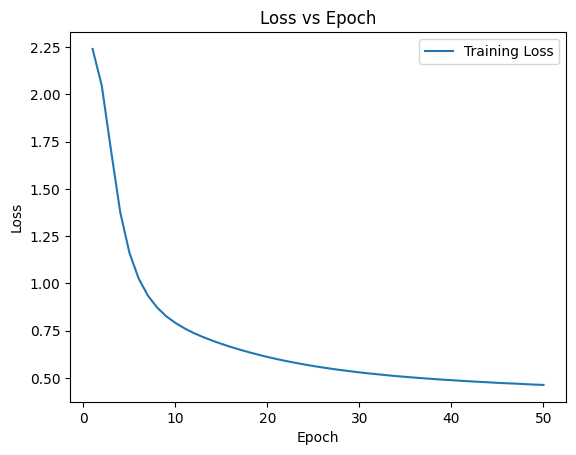

In [9]:
# Plotting all losses using matplotlib

epochs = range(1, len(all_losses) + 1)

plt.plot(epochs, all_losses, label="Training Loss")

# Labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.show()

## Testing Loops

In [11]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total_losses = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            pred = model(images)
            loss = loss_fn(pred, labels)
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()
            total_losses.append(loss.item())

    total_loss = sum(total_losses) / len(total_losses)
    print(f"Total Loss: {total_loss:.4f}")
    print(f"Accuracy: {(correct / len(test_datasets)) * 100:.2f}%")

test_model(model, test_dataloader)

Total Loss: 0.4910
Accuracy: 82.76%
